<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="BS"></a><h1 style="text-align:center;">Hawkes process simulation</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../" not in sys.path:
    sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import ks_2samp, kstest
from itertools import product

from volterra_hawkes.iVi.iVi_hawkes import IVIHawkesProcess
from volterra_hawkes.kernel.kernels import *
from volterra_hawkes.point_processes.hawkes import simulate_hawkes, simulate_hawkes_ogata, U_from_jumps, lam_from_jumps, N_from_jumps
from volterra_hawkes.utility.visualisation import Experiment, get_N_U_sample, get_arrivals_sample, plot_trajectories, plot_marginal_laws, poisson_jumps_test

plt.style.use('seaborn-v0_8-deep')
plt.style.use('default')  # 'default' or any other light theme like 'seaborn-white'

color_cycle = ["#B56246", "#579F40", "#9A46B5", "#4699B5", "#B54662", "#D4A017", "#5b6c64", "#71074E", "#0033A0"]
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=color_cycle)

## Visualisation of the trajectories

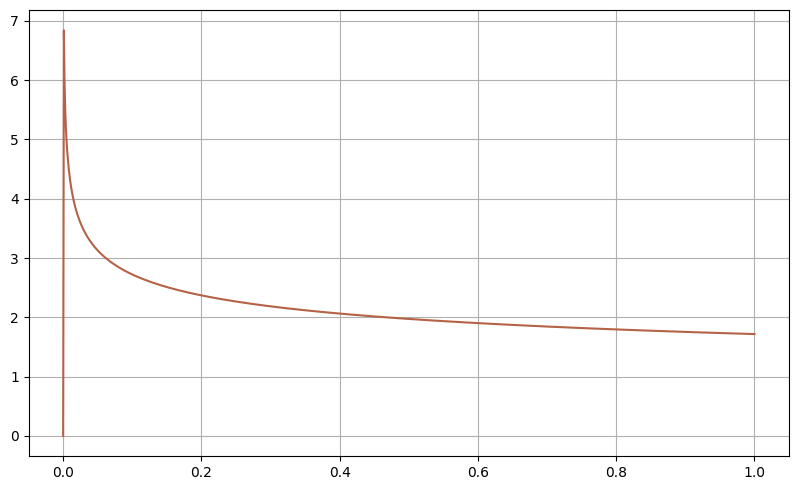

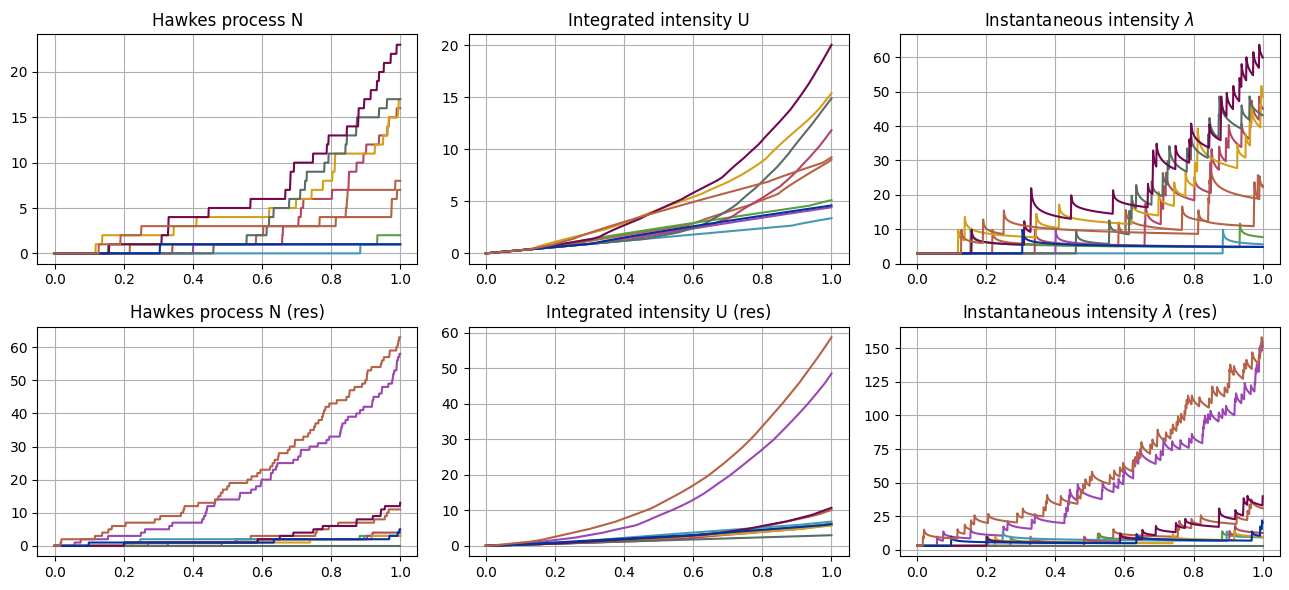

In [2]:
# mu = 3
# H = 0.3
# lam = 1
# c = 2
# alpha = 2

# T = 1
# n_steps = 1000

# rng = np.random.default_rng(seed=42)

#K = ConstantKernel(c=3)
#K = FractionalKernel(H=H, c=c)
#K = ExponentialKernel(c=c, lam=lam)
#K = GammaKernel(lam=lam, alpha=alpha, c=lam**alpha)
e = Experiment(
    T=1,
    n_steps = 1000,
    kernel = FractionalKernel(H=0.3, c=2),
    mu=3
)

# e = Experiment(
#     T=0.5,
#     n_steps = 10,
#     kernel = ConstantKernel(c=2),
#     mu=3
# )

plt.plot(e.t_grid, e.kernel(e.t_grid))

plot_trajectories(e)


# Sanity check: $\mathbb{E}[N_T]$

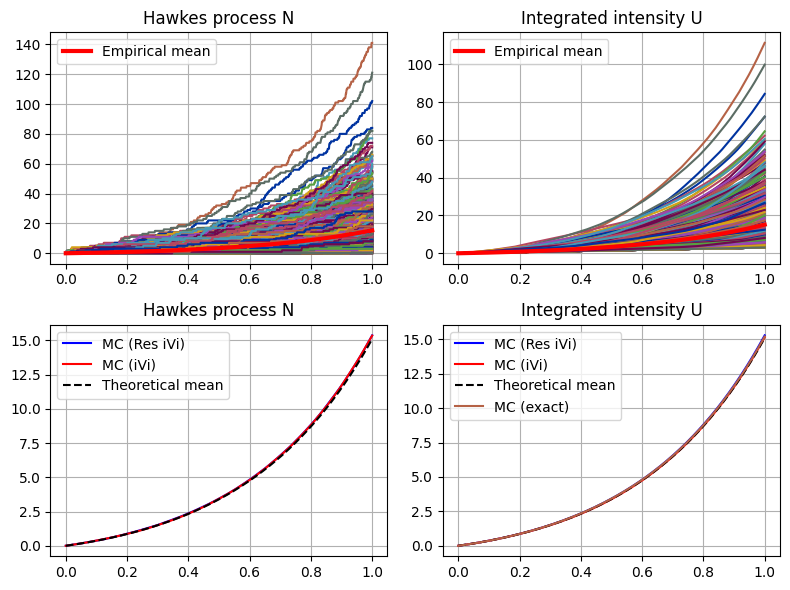

In [3]:
rng = np.random.default_rng(seed=42)
n_show = 1000
n_paths = 10000

ivi_hawkes = IVIHawkesProcess(kernel=e.kernel, g0_bar=e.g0_bar, rng=rng, g0=e.g0)
ivi_hawkes_res = IVIHawkesProcess(kernel=e.kernel, g0_bar=e.g0_bar_res, g0_bar_res=e.g0_bar_res, rng=rng, g0=e.g0, resolvent_flag=True)

N, U, lam = ivi_hawkes.simulate_on_grid(t_grid=e.t_grid, n_paths=n_paths)
N_res, U_res, lam_res = ivi_hawkes_res.simulate_on_grid(t_grid=e.t_grid, n_paths=n_paths)

expected_U = ivi_hawkes.U_mean(t_grid=e.t_grid)

hawkes_arrivals_sample = [simulate_hawkes(T=e.T, g0=e.g0, g0_upper_bound=e.mu, kernel=e.kernel, rng=rng) for _ in range(n_paths)]
N_T_sample = np.array([len(hawkes_arrivals) for hawkes_arrivals in hawkes_arrivals_sample])
U_sample = np.array([U_from_jumps(e.t_grid, hawkes_arrivals, e.kernel, e.g0_bar) for hawkes_arrivals in hawkes_arrivals_sample])
expected_U_mc = np.mean(U_sample, axis = 0)
                      
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ax[0, 0].plot(e.t_grid, N[:, 0:n_show])
ax[0, 0].plot(e.t_grid, N.mean(axis=1), "r", lw=3, label="Empirical mean")
ax[0, 0].set_title('Hawkes process N')
ax[0, 0].legend()
ax[0, 0].grid("on")

ax[0, 1].plot(e.t_grid, U[:,0:n_show])
ax[0, 1].plot(e.t_grid, U.mean(axis=1), "r", lw=3, label="Empirical mean")
ax[0, 1].set_title('Integrated intensity U')
ax[0, 1].legend()
ax[0, 1].grid("on")

ax[1, 0].plot(e.t_grid, N_res.mean(axis=1), "b", label="MC (Res iVi)")
ax[1, 0].plot(e.t_grid, N.mean(axis=1), "r", label="MC (iVi)")
ax[1, 0].plot(e.t_grid, expected_U, "k--", label="Theoretical mean")
ax[1, 0].set_title('Hawkes process N')
ax[1, 0].legend()
ax[1, 0].grid("on")

ax[1, 1].plot(e.t_grid, U_res.mean(axis=1), "b", label="MC (Res iVi)")
ax[1, 1].plot(e.t_grid, U.mean(axis=1), "r", label="MC (iVi)")
ax[1, 1].plot(e.t_grid, expected_U, "k--", label="Theoretical mean")
ax[1, 1].plot(e.t_grid, expected_U_mc, label = "MC (exact)")
ax[1, 1].set_title('Integrated intensity U')
ax[1, 1].legend()
ax[1, 1].grid("on")

plt.show()

In [5]:
expected_U[-1]

15.093161637408066

C:\Users\DM6579\AppData\Local\Temp\ipykernel_29260\1889027837.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(e.t_grid, np.abs(U_res.mean(axis = 1) - expected_U) / expected_U, label = "Res iVi")
C:\Users\DM6579\AppData\Local\Temp\ipykernel_29260\1889027837.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(e.t_grid, np.abs(U.mean(axis = 1) - expected_U) / expected_U, label = "iVi")
C:\Users\DM6579\AppData\Local\Temp\ipykernel_29260\1889027837.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(e.t_grid, np.abs(expected_U_mc - expected_U) / expected_U, label = "Exact")


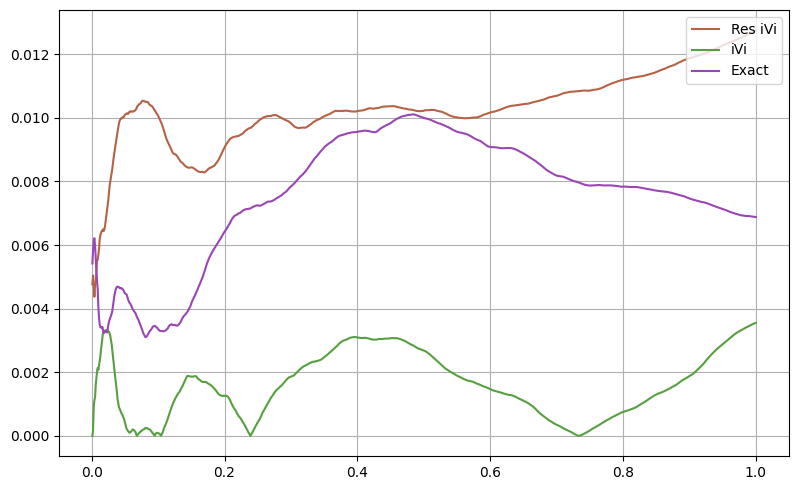

In [6]:
plt.plot(e.t_grid, np.abs(U_res.mean(axis = 1) - expected_U) / expected_U, label = "Res iVi")
plt.plot(e.t_grid, np.abs(U.mean(axis = 1) - expected_U) / expected_U, label = "iVi")
plt.plot(e.t_grid, np.abs(expected_U_mc - expected_U) / expected_U, label = "Exact")
plt.legend(loc=1)
plt.show()

# I. Marginal Laws of $N_T$ and $U_T$

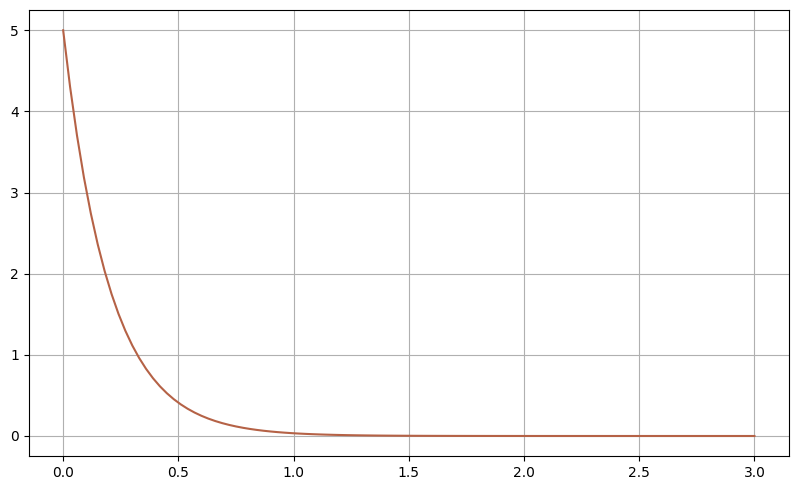

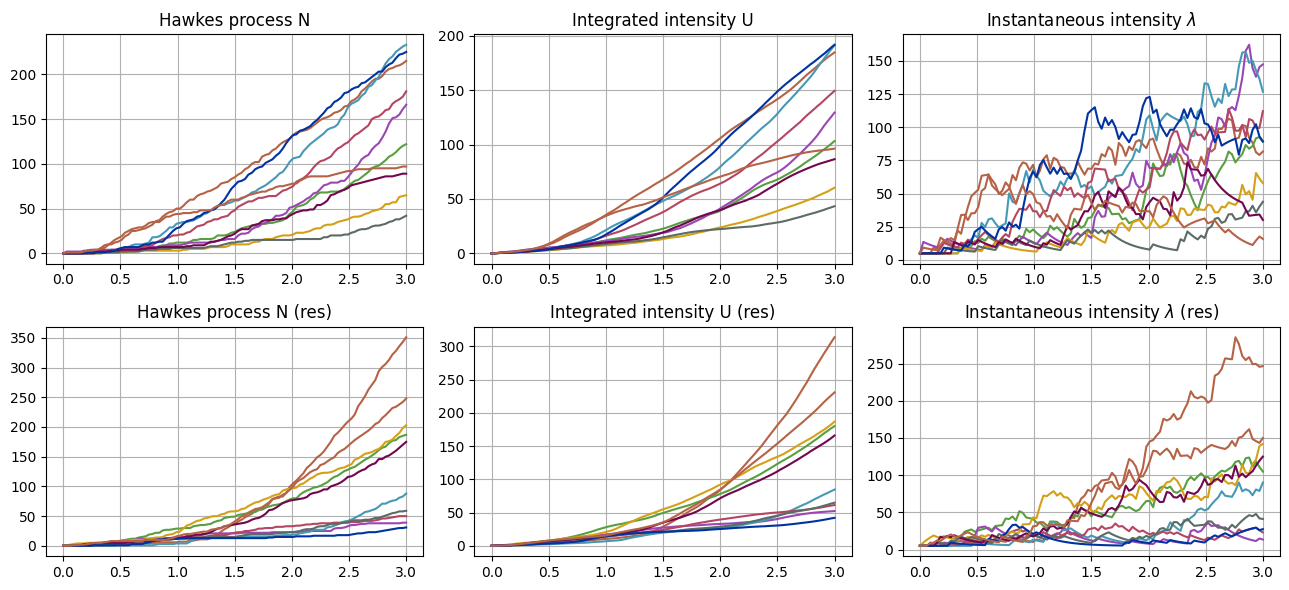

In [7]:
# H = 0.1
# c = 1
# lam = 2
# alpha = 2
# mu = 10
# T = 1

# kernel = FractionalKernel(c=c, H=H)
# kernel = ExponentialKernel(c=c, lam=lam)
# kernel = GammaKernel(lam=lam, alpha=alpha, c=lam**alpha * 0.95)
# kernel = ConstantKernel(c = 5)
rng = np.random.default_rng(seed=42)

# e = Experiment(
#     T=1,
#     n_steps = 20,
#     kernel = ConstantKernel(c = 0.9),
#     mu=3
# )

# e = Experiment(
#     T=1,
#     n_steps = 100,
#     kernel = FractionalKernel(H=0.3, c=3),
#     mu=5
# )

e = Experiment(
    T=3,
    n_steps = 100,
    kernel = ExponentialKernel(c=5, lam=5),
    mu=5
)

plt.plot(e.t_grid, e.kernel(e.t_grid))

plot_trajectories(e)

In [26]:
%%time

n_paths = 5000

methods = ["Population", "Ogata", "iVi", "Res iVi"]
samples = {method: get_N_U_sample(experiment=e, method=method, n_paths=n_paths, return_counters=True) for method in methods}

CPU times: total: 39.4 s
Wall time: 42.1 s


In [27]:
np.min(samples["Res iVi"][1][:, -1]), np.min(samples["iVi"][1][:, -1])

(22.45972955525005, 21.774209173595956)

In [28]:
np.mean(samples["Res iVi"][1][:, -1]), np.mean(samples["iVi"][1][:, -1])

(126.28000091411343, 122.25063218378929)

p-value Population-Ogata: 0.6440707891281565
KstestResult(statistic=0.0148, pvalue=0.6440707891281565, statistic_location=144.76989476257185, statistic_sign=-1)
p-value Population-iVi: 0.023582091943320466
KstestResult(statistic=0.0298, pvalue=0.023582091943320466, statistic_location=138.7740374143453, statistic_sign=1)
p-value Population-Res iVi: 0.8073761670585852
KstestResult(statistic=0.0128, pvalue=0.8073761670585852, statistic_location=114.59588218482894, statistic_sign=1)


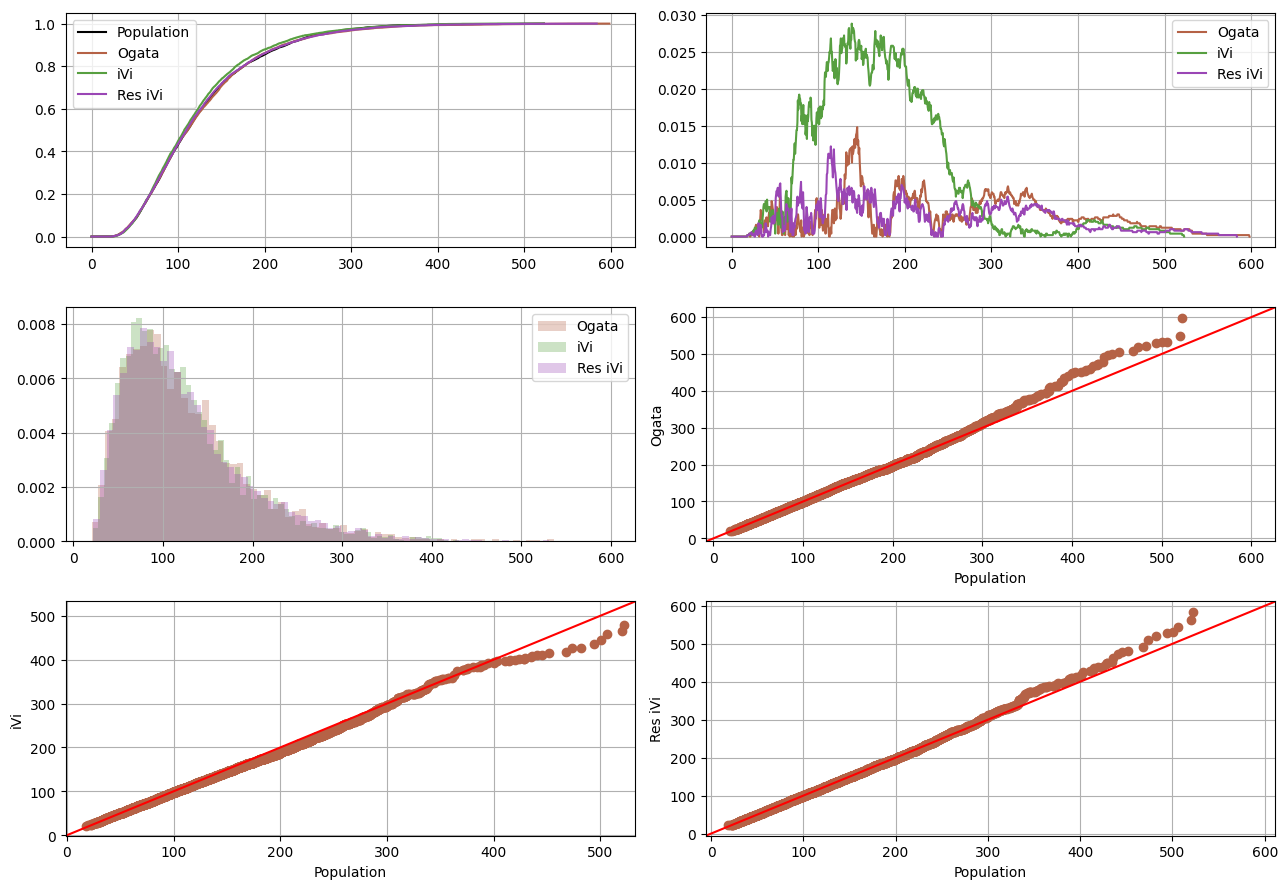

In [30]:
plot_marginal_laws(samples, "U")

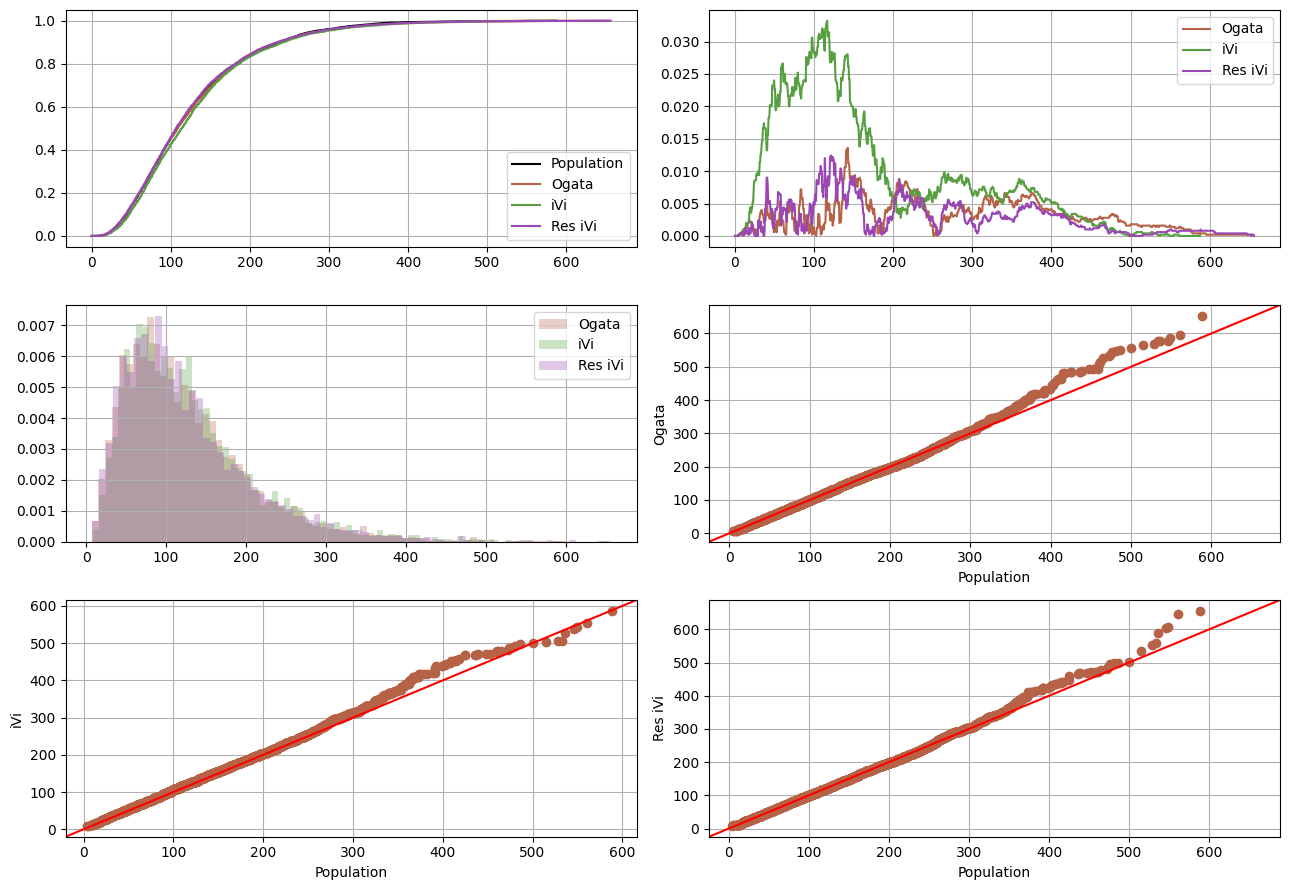

In [31]:
plot_marginal_laws(samples, "N")

### Convergence rate

In [16]:
%%time

methods = ["iVi", "Res iVi"]
n_steps_arr = [10, 20, 35, 50, 65, 80, 100, 200]
n_paths = 1_000_000

experiments = [e.change_n_steps(n_steps=n_steps) for n_steps in n_steps_arr]

samples = {(method, e.n_steps): get_N_U_sample(experiment=e, method=method, n_paths=n_paths, return_counters=True) for method, e in product(methods, experiments)}

CPU times: total: 8min 54s
Wall time: 3min 16s


In [17]:
%%time
methods_non_ivi = ["Population", "Ogata"]
n_paths_non_ivi = 10_000
samples_non_ivi = {method: get_N_U_sample(experiment=experiments[-1], method=method, n_paths=n_paths_non_ivi, return_counters=True) for method in methods_non_ivi}

CPU times: total: 1min 18s
Wall time: 1min 26s


In [20]:
w = -0.01
fun = lambda x: np.exp(w * x)
cf_ref = {}

for mode in ["U", "N"]:
    idx = 1 if mode == "U" else 0

    rng = np.random.default_rng(seed=42)
    ivi = IVIHawkesProcess(kernel=experiments[-1].kernel, g0_bar=experiments[-1].g0_bar, rng=rng, g0=experiments[-1].g0, resolvent_flag=False)
    cf_ref[mode] = ivi.characteristic_function(T=experiments[-1].T, w=w, n_steps=10000, mode=mode)

Reference value: 0.3405542836722393
Reference value: 0.3570225761120757


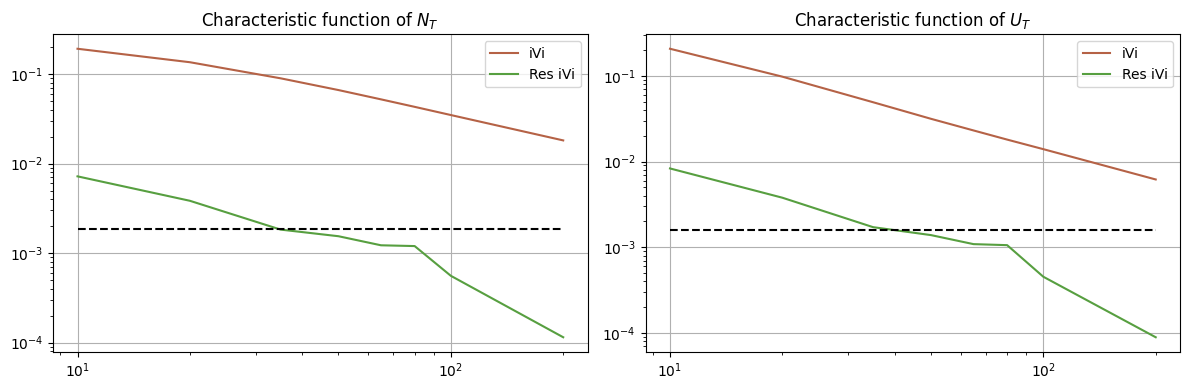

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

errors_ivi = {}
for mode in ["U", "N"]:
    idx = 1 if mode == "U" else 0
    print("Reference value:", cf_ref[mode])

    mc_std = 3 * fun(samples_non_ivi["Population"][idx][:, -1]).std() / np.sqrt(n_paths)

    errors_ivi[mode] = {}
    methods = ["iVi", "Res iVi"]

    for method in methods:
        errors_ivi[mode][method]  = []
        for e in experiments:
            U = samples[(method, e.n_steps)][idx]
            errors_ivi[mode][method].append(np.abs(cf_ref[mode] - fun(U[:, -1]).mean()))
        ax[idx].loglog(n_steps_arr, errors_ivi[mode][method], label=method)
    ax[idx].hlines(y=3 * mc_std, xmin=n_steps_arr[0], xmax=n_steps_arr[-1], color="k", linestyles="--")
    ax[idx].set_title(f"Characteristic function of ${mode}_T$")
    ax[idx].legend()

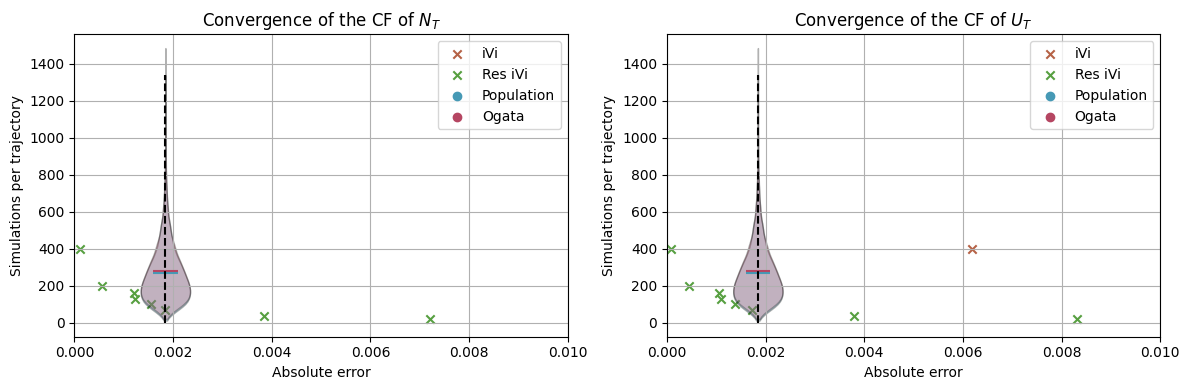

In [22]:
fig, ax_arr = plt.subplots(1, 2, figsize=(12, 4))

for mode in ["U", "N"]:
    idx = 1 if mode == "U" else 0
    ax = ax_arr[idx]
    for method in methods:
        ax.scatter(errors_ivi[mode][method], 2 * np.array(n_steps_arr), marker="x", label=method)

    for method, color in zip(methods_non_ivi, color_cycle[3:]):
        error = np.abs(cf_ref[mode] - fun(samples_non_ivi[method][idx][:, -1]).mean())
        parts= ax.violinplot(samples_non_ivi[method][2], positions=[3*mc_std], widths=0.001, showmeans=True, showextrema=False)
        ax.scatter([], [], c=color, label=method)
        for pc in parts['bodies']:
            pc.set_facecolor(color)  # blue fill
            pc.set_edgecolor('black')    # black outline
        parts['cmeans'].set_color(color)

    ax.vlines(x=3*mc_std, ymin=0, ymax=np.max(samples_non_ivi["Ogata"][2]), color="k", linestyles="--")

    ax.legend()
    ax.set_xlim([0, 0.01])
    ax.set_xlabel("Absolute error")
    ax.set_ylabel("Simulations per trajectory")
    ax.set_title(f"Convergence of the CF of ${mode}_T$")

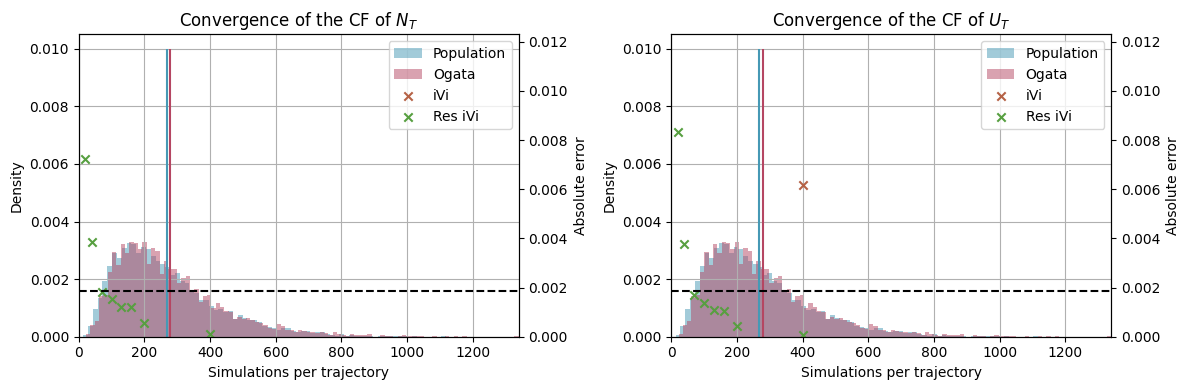

In [24]:
fig, ax_arr = plt.subplots(1, 2, figsize=(12, 4))

for mode in ["U", "N"]:
    idx = 1 if mode == "U" else 0
    ax = ax_arr[idx]

    for method, color in zip(methods_non_ivi, color_cycle[3:]):
        error = np.abs(cf_ref[mode] - fun(samples_non_ivi[method][idx][:, -1]).mean())
        ax.hist(samples_non_ivi[method][2], color=color, label=method, density=True, bins=100, alpha=0.5)
        ax.vlines(np.mean(samples_non_ivi[method][2]), 0, 0.01, color=color)

    ax.set_xlim([0, np.max(samples_non_ivi["Ogata"][2])])

    # Create second y-axis
    ax2 = ax.twinx()

    for method in methods:
        ax2.scatter(2 * np.array(n_steps_arr), errors_ivi[mode][method],  marker="x", label=method)

    ax2.hlines(y=3*mc_std, xmin=0, xmax=np.max(samples_non_ivi["Ogata"][2]), color="k", linestyles="--")
    ax2.set_ylim([0, 20*mc_std])


    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2)
    ax2.grid(False)

    ax.set_xlabel("Simulations per trajectory")
    ax.set_ylabel("Density")

    # ax.set_xlim([0, 0.01])
    ax2.set_ylabel("Absolute error")
    ax.set_title(f"Convergence of the CF of ${mode}_T$")

# II. Distribution of arriavals

## Simulation of arrivals

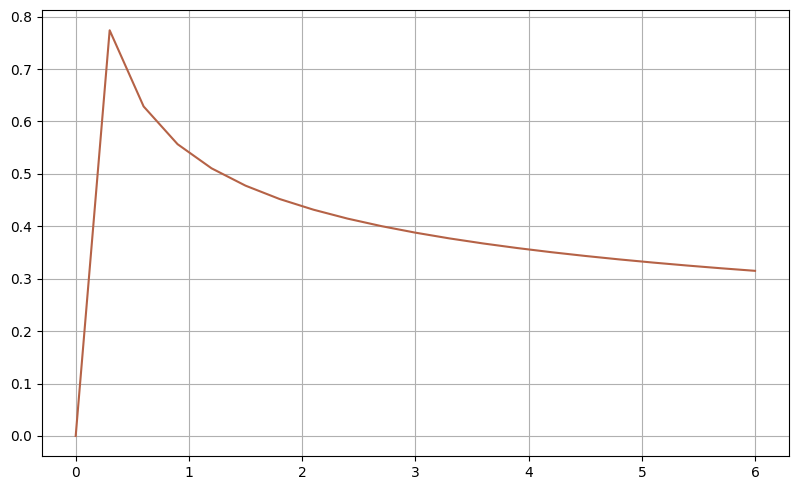

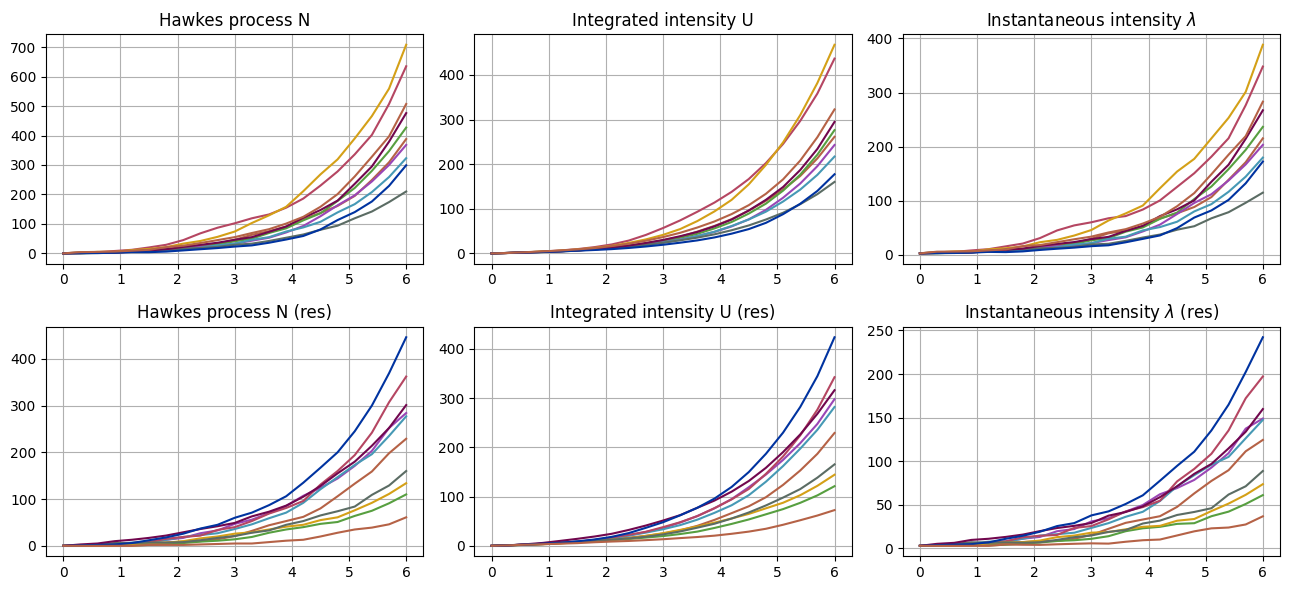

In [35]:
# H = 0.3
# lam = 1.1
# c = 1
# alpha = 2.5

# T = 10
# n_steps = 100
# n_paths = 1

# t_grid = np.linspace(0, T, n_steps + 1)

# rng = np.random.default_rng(seed = 42)


# # K = FractionalKernel(H=H, c=c)
# K = ExponentialKernel(lam=lam, c=c)
# K = GammaKernel(lam=lam, alpha=alpha, c=lam**alpha * 0.95)

# e = Experiment(
#     T=10, 
#     n_steps=1, 
#     kernel=ExponentialKernel(lam=1.1, c=1), 
#     mu=3
# )

e = Experiment(
    T=6, 
    n_steps=20,
    kernel=FractionalKernel(H=0.2, c=0.7), 
    mu=3
)

plt.plot(e.t_grid, e.kernel(e.t_grid))
plot_trajectories(e)

Population
Kolmogorov-Smirnov test p-value:  0.44964480178826527


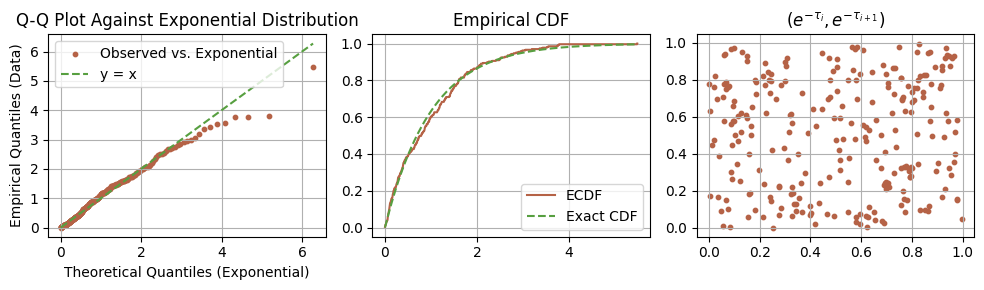

Ogata
Kolmogorov-Smirnov test p-value:  0.6073219308180429


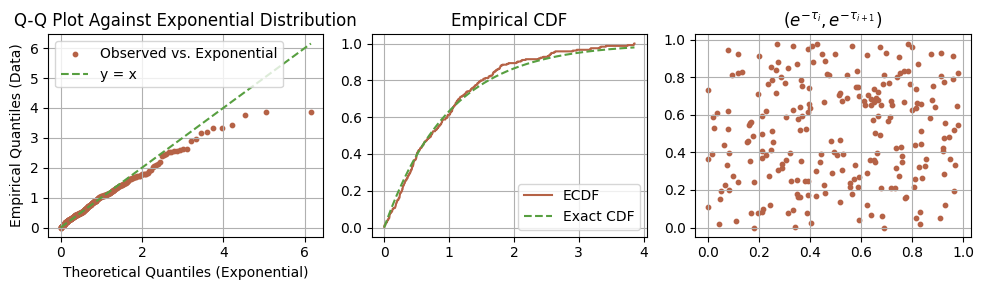

iVi
Kolmogorov-Smirnov test p-value:  0.4629395834368474


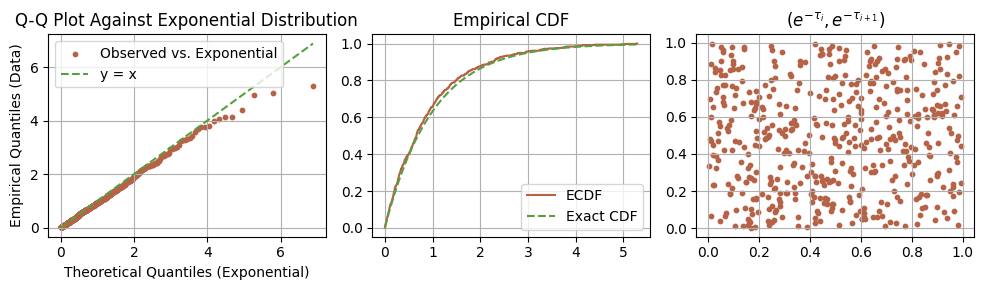

Res iVi
Kolmogorov-Smirnov test p-value:  0.7224499240459454


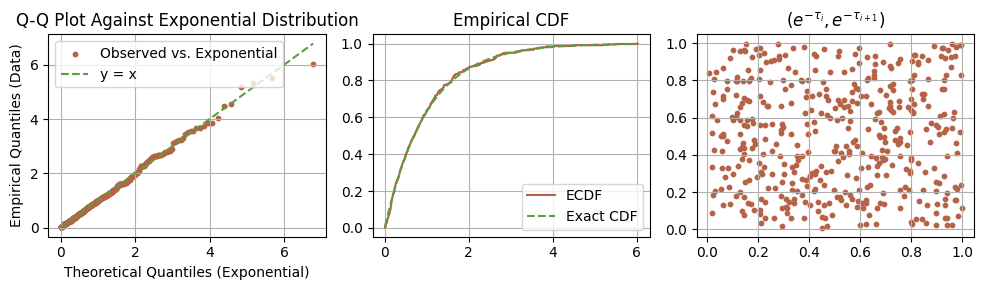

In [36]:
methods = ["Population", "Ogata", "iVi", "Res iVi"]

for method in methods:
    samples_arrivals = get_arrivals_sample(experiment=e, method=method, n_paths=1, rng=rng)
    print(method)
    ivi_hawkes = IVIHawkesProcess(kernel=e.kernel, g0_bar=e.g0_bar, rng=rng, g0=e.g0, resolvent_flag=False)
    poisson_jumps_test(ivi_hawkes.U_from_jumps(samples_arrivals[0], samples_arrivals[0]))